# E-commerce Product recommendation System

## Importing libraries

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

## Loading Dataset

In [3]:
df = pd.read_csv('raw/ratings.csv')
df = df.dropna()
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [4]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  2023070
No of columns =  4


### Datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


### Missing value analysis

In [6]:
# Find number of missing values in each column
df.isna().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

### Summary

In [7]:
# Summary statistics of 'rating' variable
df['Rating'].describe()

count    2.023070e+06
mean     4.149036e+00
std      1.311505e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

### Rating distribution

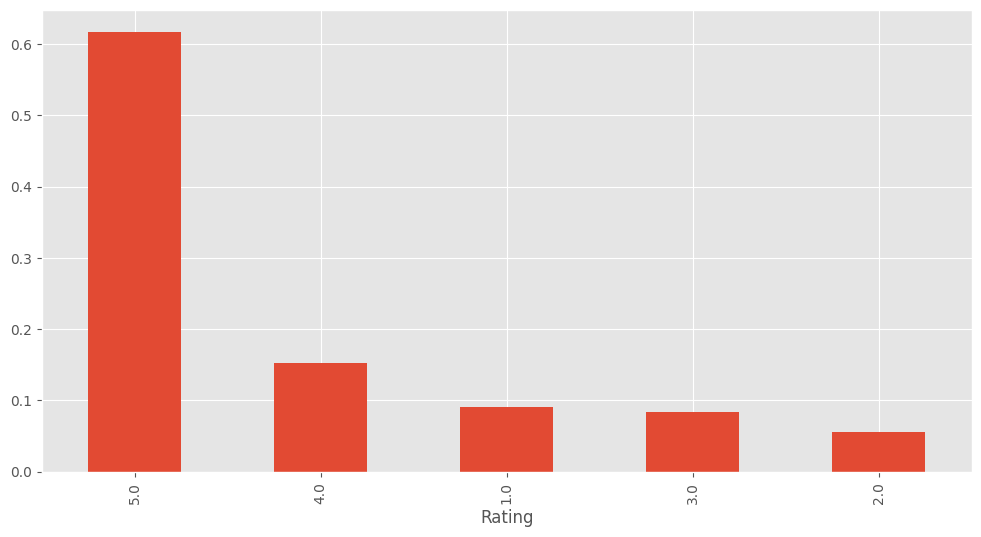

In [8]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['Rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [9]:
df.shape

(2023070, 4)

In [10]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['UserId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['ProductId'].nunique())

Number of unique USERS in Raw data =  1210271
Number of unique ITEMS in Raw data =  249274


### Users with most no of rating

In [11]:
# Top 10 users based on rating
most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated

UserId
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
ALQGOMOY1F5X9     275
AKMEY1BSHSDG7     269
A3R9H6OKZHHRJD    259
A1M04H40ZVGWVG    249
A1RRMZKOMZ2M7J    225
dtype: int64

## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [12]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 50].index)]

In [13]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['UserId'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['ProductId'].nunique())

The number of observations in the final data = 29559
Number of unique USERS in the final data =  361
Number of unique PRODUCTS in the final data =  17228


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [14]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (361, 17228)
given_num_of_ratings =  29559
possible_num_of_ratings =  6219308
density: 0.48%


ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y59HW4O47N0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A110PQTEI6THU7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System

In [16]:
#Calculate the average rating for each product
average_rating = df_final.groupby('ProductId').mean(numeric_only=True)['Rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('ProductId').count()['Rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
ProductId,,
0762451459,5.0,1
B004JAZGOC,5.0,1
B004ITB3IW,5.0,6
B004ITYX52,5.0,1
B004IVM0EG,5.0,1


In [17]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

## Recommending top 5 products with 50 minimum interactions based on popularity

In [18]:
list(top_n_products(final_rating, 5, 50))

['B00AE0790U', 'B009FKNGGQ']

## Recommending top 5 products with 100 minimum interactions based on popularity

In [19]:
list(top_n_products(final_rating, 5, 100))

[]

# Collaborative Filtering based Recommendation System

## User based collaborative filtering

In [20]:
final_ratings_matrix.head()

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y59HW4O47N0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A110PQTEI6THU7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, UserId (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [21]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to find Similar users and their similarity scores

In [58]:
# Defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        # Finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.iloc[user_index]], [interactions_matrix.iloc[user]])

        # Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    # Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 1 and their similarity score

In [60]:
similar = similar_users(1, final_ratings_matrix)[0][0:10]
similar

[126, 72, 30, 323, 272, 239, 163, 44, 214, 308]

In [61]:
#Print the similarity score
similar_users(1,final_ratings_matrix)[1][0:10]

[array([[0.05930774]]),
 array([[0.04092788]]),
 array([[0.03999809]]),
 array([[0.03507881]]),
 array([[0.034761]]),
 array([[0.03473375]]),
 array([[0.03357002]]),
 array([[0.03054464]]),
 array([[0.02930463]]),
 array([[0.0287997]])]

#### Finding out top 10 similar users to the user index 360 and their similarity score

In [62]:
similar = similar_users(360, final_ratings_matrix)[0][0:10]
similar

[57, 42, 226, 109, 24, 353, 89, 115, 182, 332]

In [63]:
#Print the similarity score
similar_users(360,final_ratings_matrix)[1][0:10]

[array([[0.05777213]]),
 array([[0.05649702]]),
 array([[0.05320896]]),
 array([[0.05301885]]),
 array([[0.05197873]]),
 array([[0.03735104]]),
 array([[0.03655981]]),
 array([[0.03635538]]),
 array([[0.03371071]]),
 array([[0.03275497]])]

### Function to recommend products

In [64]:
def recommendations(user_index, num_of_products, interactions_matrix):
    # Save similar users using the modified similar_users function
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    # Finding product IDs with which the user has interacted
    # Using np.where with iloc for safer indexing
    user_interactions = interactions_matrix.iloc[user_index] > 0
    prod_ids = set(interactions_matrix.columns[user_interactions])

    recommendations = []
    observed_interactions = prod_ids.copy()

    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            # Finding products rated by similar users but not by the target user
            similar_user_interactions = interactions_matrix.iloc[similar_user] > 0
            similar_user_prod_ids = set(interactions_matrix.columns[similar_user_interactions])
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))

            # Update observed interactions
            observed_interactions.update(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [65]:
recommendations(3,5,final_ratings_matrix)

['B000AO2NXS', 'B008UVO5DY', 'B00AACBZMA', 'B004NFTGA8', 'B004S6BXLW']

#### Recommend 5 products to user index 360 based on similarity based collaborative filtering

In [66]:
recommendations(360,5,final_ratings_matrix)

['B004BCT7G6', 'B000HZ9K3G', 'B0068G8DTA', 'B006UETDGC', 'B002LA1D9Y']

# Model based Collaborative Filtering: Singular Value Decomposition

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix

In [67]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [68]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [69]:
U.shape

(361, 50)

In [70]:
sigma.shape

(50, 50)

In [71]:
Vt.shape

(50, 17228)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [86]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
0,0.047090,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,...,0.015907,0.015907,1.426274e-02,0.039624,0.031367,0.023621,0.015907,0.007613,0.100581,0.011551
1,0.000417,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,...,0.001455,0.001455,4.574687e-03,0.024927,0.002310,0.114070,0.001455,0.000406,0.028418,0.011666
2,0.004305,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,...,0.001272,0.001272,9.245031e-03,0.010621,0.002462,0.002917,0.001272,0.007446,0.008230,0.021596
3,0.000094,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,0.000119,0.000119,7.511873e-07,0.000021,0.000225,0.000218,0.000119,0.000432,0.000316,0.000302
4,0.011773,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,...,0.000615,0.000615,2.893702e-03,0.014905,0.001234,0.009558,0.000615,0.002654,0.016044,0.010468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.008739,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,...,0.000255,0.000255,1.965799e-02,0.010638,0.000444,0.038776,0.000255,0.000711,0.014333,0.011379
357,0.013831,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.023049,0.023049,1.994530e-01,0.657957,0.041853,0.036075,0.023049,0.005746,0.535951,0.002318
358,0.030802,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,...,0.005789,0.005789,1.723939e-02,0.033548,0.011656,0.021254,0.005789,0.049421,0.014373,0.030115
359,0.025005,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,...,0.001754,0.001754,2.137811e-02,0.096937,0.002387,0.047455,0.001754,0.001803,0.009459,0.064155


In [83]:
preds_matrix = csr_matrix(preds_df.values)

<361x17228 sparse matrix of type '<class 'numpy.float64'>'
	with 6219308 stored elements in Compressed Sparse Row format>

## Function to recommend products

In [73]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Recommending top 5 products to user id 121

In [74]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
12323    0.231035
4560     0.180850
5700     0.170876
7164     0.168580
361      0.167992
Name: user_predictions, dtype: float64


### Recommending top 10 products to user id 100

In [75]:
recommend_items(100,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
14738    1.111167
14433    0.986382
14431    0.968452
14590    0.926752
3626     0.889151
12508    0.879329
14426    0.833219
14871    0.825405
12509    0.798574
14875    0.798140
Name: user_predictions, dtype: float64


## Evaluating the model

In [76]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

ProductId
0762451459    0.01385
1304482596    0.00277
1304482685    0.00277
1304495396    0.00277
1304511111    0.00277
dtype: float64

In [78]:
preds_df.head()

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
0,0.047090,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,...,0.015907,0.015907,1.426274e-02,0.039624,0.031367,0.023621,0.015907,0.007613,0.100581,0.011551
1,0.000417,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,...,0.001455,0.001455,4.574687e-03,0.024927,0.002310,0.114070,0.001455,0.000406,0.028418,0.011666
2,0.004305,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,...,0.001272,0.001272,9.245031e-03,0.010621,0.002462,0.002917,0.001272,0.007446,0.008230,0.021596
3,0.000094,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,0.000119,0.000119,7.511873e-07,0.000021,0.000225,0.000218,0.000119,0.000432,0.000316,0.000302
4,0.011773,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,...,0.000615,0.000615,2.893702e-03,0.014905,0.001234,0.009558,0.000615,0.002654,0.016044,0.010468


In [79]:
avg_preds=preds_df.mean()
avg_preds.head()

ProductId
0762451459    0.043818
1304482596    0.000441
1304482685    0.000441
1304495396    0.000441
1304511111    0.000441
dtype: float64

In [80]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
ProductId,,
0762451459,0.01385,0.043818
1304482596,0.00277,0.000441
1304482685,0.00277,0.000441
1304495396,0.00277,0.000441
1304511111,0.00277,0.000441


In [81]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.026487939760784365 



c:\Users\NailFerroukhi\miniconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
